<a href="https://colab.research.google.com/github/toraaglobal/CaseStudies/blob/master/Choosing_Housing_Values.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# CHOOSING HOUSING VALUES
# BASED ON MILLER (2015)

# import packages for analysis and modeling
import pandas as pd  # data frame operations
from pandas.plotting import scatter_matrix  # scatter plot matrix
from pandas import Series
import numpy as np  # arrays and math functions
from scipy.stats import uniform  # for training-and-test split
import statsmodels.api as sm  # statistical models (including regression)
import statsmodels.formula.api as smf  # R-like model specification
from sklearn.tree import DecisionTreeRegressor  # machine learning tree
from sklearn.ensemble import RandomForestRegressor # ensemble method
from matplotlib import pyplot
import seaborn as sns

%matplotlib inline


In [3]:
#Mount the gdrive
import os
from google.colab import drive
drive.mount('/content/drive')


#change directry to the gdrive

os.chdir('./drive/My Drive/Colab Notebooks/data')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
# read in the housing data with white-space delimiters
prelim_houses = pd.read_table('./houses_data.txt', header = None,delim_whitespace = True, skipinitialspace = True,names = ['value', 'income', 'age', 'rooms', 'bedrooms','pop', 'hh', 'latitude', 'longitude'])

prelim_houses['idx'] = range(len(prelim_houses))  # for use as index
houses = prelim_houses.set_index(['idx']) 
     
print(houses.shape)  # check the structure of the data frame
print(houses.head())

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  """Entry point for launching an IPython kernel.


(20640, 9)
        value  income   age   rooms  bedrooms     pop      hh  latitude  \
idx                                                                       
0    452600.0  8.3252  41.0   880.0     129.0   322.0   126.0     37.88   
1    358500.0  8.3014  21.0  7099.0    1106.0  2401.0  1138.0     37.86   
2    352100.0  7.2574  52.0  1467.0     190.0   496.0   177.0     37.85   
3    341300.0  5.6431  52.0  1274.0     235.0   558.0   219.0     37.85   
4    342200.0  3.8462  52.0  1627.0     280.0   565.0   259.0     37.85   

     longitude  
idx             
0      -122.23  
1      -122.22  
2      -122.24  
3      -122.25  
4      -122.25  


In [6]:
# compute descriptive statistics for original variables
print(houses.describe().T)


             count           mean            std         min          25%  \
value      20640.0  206855.816909  115395.615874  14999.0000  119600.0000   
income     20640.0       3.870671       1.899822      0.4999       2.5634   
age        20640.0      28.639486      12.585558      1.0000      18.0000   
rooms      20640.0    2635.763081    2181.615252      2.0000    1447.7500   
bedrooms   20640.0     537.898014     421.247906      1.0000     295.0000   
pop        20640.0    1425.476744    1132.462122      3.0000     787.0000   
hh         20640.0     499.539680     382.329753      1.0000     280.0000   
latitude   20640.0      35.631861       2.135952     32.5400      33.9300   
longitude  20640.0    -119.569704       2.003532   -124.3500    -121.8000   

                   50%           75%          max  
value      179700.0000  264725.00000  500001.0000  
income          3.5348       4.74325      15.0001  
age            29.0000      37.00000      52.0000  
rooms        2127.000

In [0]:
# computed variables for linear model used by Pace and Barry (1997)
houses['log_value'] = np.log(houses['value'])
houses['income_squared'] = np.power(houses['income'], 2) 
houses['income_cubed'] = np.power(houses['income'], 3) 
houses['log_age'] = np.log(houses['age'])   
houses['log_pc_rooms'] = np.log(np.divide(houses['rooms'], houses['pop']))       
houses['log_pc_bedrooms'] = \
    np.log(np.divide(houses['bedrooms'], houses['pop']))                   
houses['log_pop_hh'] = np.divide(houses['pop'], houses['hh'])           
houses['log_hh'] = np.log(houses['hh']) 

In [0]:
# structure of the Pace and Barry (1997) model for baseline for comparisons

pace_barry_model = 'log_value ~ income + income_squared + income_cubed + log_age + log_pc_rooms + log_pc_bedrooms + log_pop_hh + log_hh'

In [0]:
# for comparison lets look at a simple model with the original variables
simple_model = 'log_value ~ income + age + rooms + bedrooms +  pop + hh' 

In [0]:
# original variables plus variables that add value for trees 
# that is... variables that are not simple monotonic transformations
# of the original explanatory variables

full_model = 'log_value ~ income + age + rooms + bedrooms + pop + hh + log_pc_rooms + log_pc_bedrooms + log_pop_hh'  
  

In [12]:
# define the bounding box for selecting the area
# here we are selecting the San Diego region
BB_TOP = 33
BB_BOTTOM = 32
BB_RIGHT = -116.75
BB_LEFT = -125

houses_selected = houses[houses['latitude'] < BB_TOP]
houses_selected = houses_selected[houses_selected['longitude'] < BB_RIGHT]
houses_selected = houses_selected[houses_selected['latitude'] > BB_BOTTOM]
houses_selected = houses_selected[houses_selected['longitude'] > BB_LEFT]

# examine structure of selected block groups
print(houses_selected.shape)
print(houses_selected.head())

(1206, 17)
          value  income   age   rooms  bedrooms    pop     hh  latitude  \
idx                                                                       
14005  441700.0  4.7396  52.0  2023.0     301.0  649.0  285.0     32.76   
14006  408500.0  5.3920  52.0  1539.0     212.0  535.0  224.0     32.75   
14007  459600.0  8.6030  52.0  1504.0     208.0  518.0  196.0     32.75   
14008  500001.0  8.1548  52.0  1495.0     230.0  459.0  190.0     32.75   
14009  411600.0  6.1309  52.0  1388.0     213.0  513.0  211.0     32.75   

       longitude  log_value  income_squared  income_cubed   log_age  \
idx                                                                   
14005    -117.18  12.998386       22.463808    106.469465  3.951244   
14006    -117.18  12.920247       29.073664    156.765196  3.951244   
14007    -117.18  13.038112       74.011609    636.721872  3.951244   
14008    -117.19  13.122365       66.500763    542.300422  3.951244   
14009    -117.19  12.927807       37.

In [13]:
# employ training-and-test regimen for model validation
np.random.seed(4444)
houses_selected['runiform'] = uniform.rvs(loc = 0, scale = 1, size = len(houses_selected))

houses_selected_train = houses_selected[houses_selected['runiform'] >= 0.33]
houses_selected_test = houses_selected[houses_selected['runiform'] < 0.33]


# check training data frame
print('\nhouses_selected_train data frame (rows, columns): ', houses_selected_train.shape)
print(houses_selected_train.head())
# check test data frame
print('\nhouses_selected_test data frame (rows, columns): ',houses_selected_test.shape)
print(houses_selected_test.head())


houses_selected_train data frame (rows, columns):  (793, 18)
          value  income   age   rooms  bedrooms    pop     hh  latitude  \
idx                                                                       
14005  441700.0  4.7396  52.0  2023.0     301.0  649.0  285.0     32.76   
14007  459600.0  8.6030  52.0  1504.0     208.0  518.0  196.0     32.75   
14008  500001.0  8.1548  52.0  1495.0     230.0  459.0  190.0     32.75   
14009  411600.0  6.1309  52.0  1388.0     213.0  513.0  211.0     32.75   
14010  500001.0  5.7914  52.0  1294.0     175.0  434.0  180.0     32.76   

       longitude  log_value  income_squared  income_cubed   log_age  \
idx                                                                   
14005    -117.18  12.998386       22.463808    106.469465  3.951244   
14007    -117.18  13.038112       74.011609    636.721872  3.951244   
14008    -117.19  13.122365       66.500763    542.300422  3.951244   
14009    -117.19  12.927807       37.587935    230.447870

                 log_value    income  log_pc_rooms  log_pc_bedrooms     rooms  \
log_value         1.000000  0.659510      0.675540         0.349961  0.157848   
income            0.659510  1.000000      0.527058        -0.106339  0.223225   
log_pc_rooms      0.675540  0.527058      1.000000         0.674607  0.190381   
log_pc_bedrooms   0.349961 -0.106339      0.674607         1.000000  0.027068   
rooms             0.157848  0.223225      0.190381         0.027068  1.000000   
bedrooms          0.029609 -0.025875      0.073820         0.151982  0.929458   
hh                0.020813 -0.015306      0.055065         0.108616  0.934255   
age               0.009355 -0.218314     -0.010232         0.093863 -0.371797   
pop              -0.092723  0.008507     -0.188314        -0.237542  0.897124   
log_pop_hh       -0.312509  0.021222     -0.674988        -0.860651 -0.040936   

                 bedrooms        hh       age       pop  log_pop_hh  
log_value        0.029609  0.020813  0

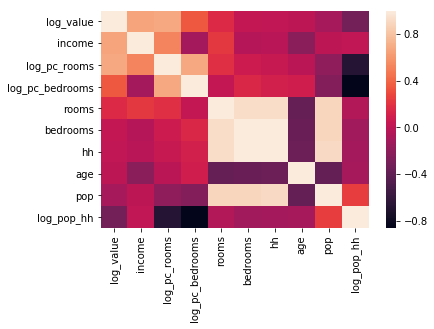

In [15]:
# examine the correlations across the variables before we begin modeling
houses_train_df_vars = houses_selected_train.loc[ : ,['log_value', 'income','log_pc_rooms', 'log_pc_bedrooms', 'rooms', 'bedrooms', 'hh', 'age', 'pop', 'log_pop_hh']]
print(houses_train_df_vars.corr())

sns.heatmap(houses_train_df_vars.corr())

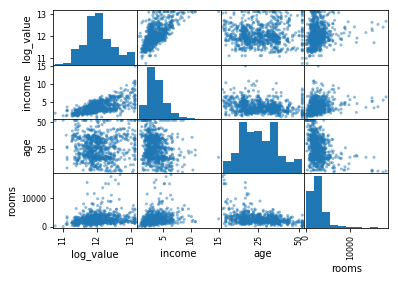

In [16]:
# scatter plot matrix (splom) demonstration
houses_train_splom_vars = houses_selected_train.loc[:, ['log_value', 'income', 'age', 'rooms']]
scatter_matrix(houses_train_splom_vars)   
pyplot.show()

In [17]:
# --------------------------------------------
# Linear regression a la Pace and Barry (1997)
# --------------------------------------------
# fit the model to the training set
pace_barry_train_fit = smf.ols(pace_barry_model, data = houses_selected_train).fit()
# summary of model fit to the training set
print(pace_barry_train_fit.summary())
# training set predictions from the model fit to the training set
houses_selected_train['predict_log_value'] = pace_barry_train_fit.fittedvalues
# test set predictions from the model fit to the training set
houses_selected_test['predict_log_value'] = pace_barry_train_fit.predict(houses_selected_test)

                            OLS Regression Results                            
Dep. Variable:              log_value   R-squared:                       0.643
Model:                            OLS   Adj. R-squared:                  0.640
Method:                 Least Squares   F-statistic:                     176.8
Date:                Wed, 08 May 2019   Prob (F-statistic):          7.51e-170
Time:                        08:19:46   Log-Likelihood:                -62.370
No. Observations:                 793   AIC:                             142.7
Df Residuals:                     784   BIC:                             184.8
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          11.3731      0.154     

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


In [18]:
# compute the proportion of response variance for training data
pace_and_barry_train_result = round(np.power(houses_selected_train['log_value'].corr(houses_selected_train['predict_log_value']),2),3)
print('\nPace and Barry Proportion of Training Set Variance Accounted for: ',pace_and_barry_train_result)


Pace and Barry Proportion of Training Set Variance Accounted for:  0.643


In [19]:
# compute the proportion of response variance
# accounted for when predicting out-of-sample
pace_and_barry_test_result = round(np.power(houses_selected_test['log_value'].corr(houses_selected_test['predict_log_value']),2),3)
print('\nPace and Barry Proportion of Test Set Variance Accounted for: ',pace_and_barry_test_result)


Pace and Barry Proportion of Test Set Variance Accounted for:  0.568


In [20]:
# --------------------------------------
# Tree-structured regression (simple)
# --------------------------------------
# try tree-structured regression on the original explantory variables
# note that one of the advantages of trees is no need for transformations
# of the explanatory variables... sklearn DecisionTreeRegressor

tree_model_maker = DecisionTreeRegressor(random_state = 9999, max_depth = 5)

y_train = houses_selected_train.loc[:, ['log_value']]

# simple model has six predictors
X_train_simple = houses_selected_train.loc[:,['income', 'age', 'rooms', 'bedrooms', 'pop', 'hh']]
X_test_simple = houses_selected_test.loc[:,['income', 'age', 'rooms', 'bedrooms', 'pop', 'hh']]

tree_model_fit = tree_model_maker.fit(X_train_simple, y_train)

# compute the proportion of response variance for training data
houses_selected_train['simple_tree_predict_log_value'] =tree_model_fit.predict(X_train_simple)
simple_tree_train_result = round(np.power(houses_selected_train['log_value'].corr(houses_selected_train['simple_tree_predict_log_value']),2),3)
print('\nSimple Tree Proportion of Training Set Variance Accounted for: ',simple_tree_train_result)

# compute the proportion of response variance for test data
houses_selected_test['simple_tree_predict_log_value'] =tree_model_fit.predict(X_test_simple)
simple_tree_test_result = round(np.power(houses_selected_test['log_value'].corr(houses_selected_test['simple_tree_predict_log_value']),2),3)
print('\nSimple Tree Proportion of Test Set Variance Accounted for: ',simple_tree_test_result)


Simple Tree Proportion of Training Set Variance Accounted for:  0.621

Simple Tree Proportion of Test Set Variance Accounted for:  0.461


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [21]:
# --------------------------------------
# Random forests (full)
# --------------------------------------
rf_model_maker = RandomForestRegressor(random_state = 9999)

y_train = houses_selected_train.loc[:, ['log_value']]

# full model has more predictors
X_train_full = houses_selected_train.loc[:, ['income', 'age', 'rooms', 'bedrooms','pop', 'hh', 'log_pc_rooms', 'log_pc_bedrooms', 'log_pop_hh']]
X_test_full = houses_selected_test.loc[:, ['income', 'age', 'rooms', 'bedrooms','pop', 'hh', 'log_pc_rooms', 'log_pc_bedrooms', 'log_pop_hh']]

rf_model_fit = rf_model_maker.fit(X_train_full, y_train)

# compute the proportion of response variance for training data
houses_selected_train['full_rf_predict_log_value'] = rf_model_fit.predict(X_train_full)
full_rf_train_result = round(np.power(houses_selected_train['log_value'].corr(houses_selected_train['full_rf_predict_log_value']),2),3)
print('\nFull Random Forest Prop of Training Set Variance Accounted for: ',full_rf_train_result)

# compute the proportion of response variance for test data
houses_selected_test['full_rf_predict_log_value'] =rf_model_fit.predict(X_test_full)
full_rf_test_result =  round(np.power(houses_selected_test['log_value'].corr(houses_selected_test['full_rf_predict_log_value']),2),3)
print('\nFull Random Forest Prop of Test Set Variance Accounted for: ',full_rf_test_result)


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':



Full Random Forest Prop of Training Set Variance Accounted for:  0.946

Full Random Forest Prop of Test Set Variance Accounted for:  0.627


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [30]:
# --------------------------------------------------
# we have been using a simple training-and-test split for validation
# an alternative is multi-fold cross-validation, as shown here
# for the simple tree-structured regression model

from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

# specify number of folds for multi-fold cross-validation
# a simple training-and-test regimen would have two folds
specified_n_folds = 5

# specify the modeling technique or method of analysis
tree_model_maker = DecisionTreeRegressor(random_state = 9999, max_depth = 5)

# specify the response variable 
y = houses_selected.loc[:, ['log_value']]

# specify the explanatory variables 
X = houses_selected.loc[:, ['income', 'age', 'rooms', 'bedrooms', 'pop', 'hh']]


score =cross_val_score(tree_model_maker, X,y, cv=specified_n_folds)

print(np.average(score))

0.2798907197641324
